In [2]:
import numpy as np
import pandas as pd
import requests

## Carga de datos

In [20]:
token_1='82908162e488cf6a1e53620862cd2d9fa1181ba5a78882ffeb5d29320a19a145'

def descargar_banxico(serie,fecha_inicio,fecha_fin,token=token_1,es_oportuno=False):
    #Donde:
    # serie: el identificador o identificadores que tiene Banxico para cada serie de tiempo en su sistema de información
    #       las series se pueden consultar en la siguiente liga: https://www.banxico.org.mx/SieAPIRest/service/v1/doc/catalogoSeries
    # fecha_inicio: fecha aaaa-mm-dd en la que se quiere iniciar la consulta
    # fecha_fin: fecha aaaa-mm-dd en la que se quiere concluir la consulta
    # token: el token generado por la API de Banxico para acceder

    if es_oportuno==True:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/oportuno?token='+token
    else:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fecha_inicio+'/'+fecha_fin+'?token='+token
    headers = {'Token':token}
    response = requests.get(url,headers=headers)
    status=response.status_code
    raw_data = response.json()
    T=len(serie.split(","))
    info={'fecha':pd.DataFrame(raw_data['bmx']['series'][0]['datos'])['fecha']}

    for i in range(T):
        titulo=raw_data['bmx']['series'][i]['titulo']

        data=raw_data['bmx']['series'][i]['datos']

        df=pd.DataFrame(data)
        df['dato'] = df['dato'].str.replace(',', '', regex=True).str.extract('(\d+\.\d+)')[0].astype(float)
        df['dato'] = df['dato'].apply(lambda x:float(x))
        info[titulo]=df['dato']
    info=pd.DataFrame(info)
    info.set_index('fecha',inplace=True)

    return info

def descargar_fred(serie,fecha_inicio,fecha_fin):
    key_2='fb3e12e05f3753283d1b617eee584598'
    url_2='https://api.stlouisfed.org/fred/series/observations?series_id='+serie+'&api_key='+key_2+'&file_type=json'
    response2 = requests.get(url_2)
    status=response2.status_code
    raw_data = response2.json()
    variable=pd.DataFrame(raw_data['observations'])[['date','value']]
    variable=variable.set_index(pd.to_datetime(list(variable.iloc[:,0]),format="%Y/%m/%d")).drop(['date'],axis=1)
    variable=variable.loc[fecha_inicio:fecha_fin]
    return pd.DataFrame(variable)

#pd.concat([ipi_us.iloc[:,0].apply(lambda x:float(x)),payroll.iloc[:,0].apply(lambda x:float(x))],axis=1)
def a_float(serie):
    return serie.iloc[:,0].apply(lambda x:float(x))

fecha_inicio='2002-01-01'
fecha_fin='2023-10-28'

ipi_us=descargar_fred('INDPRO',fecha_inicio,fecha_fin)
construc_us=descargar_fred('IPB54100S',fecha_inicio,fecha_fin)
manuf_us=descargar_fred('IPMAN',fecha_inicio,fecha_fin)
payroll=descargar_fred('PAYEMS',fecha_inicio,fecha_fin)
payroll=descargar_fred('PAYEMS',fecha_inicio,fecha_fin)
cpi_us=descargar_fred('CPIAUCSL','2001-01-01',fecha_fin)

remesas=descargar_banxico('SE27803',fecha_inicio,fecha_fin)
usdmxn_mensual=descargar_banxico('SF17908',fecha_inicio,fecha_fin)
usdmxn_diaria=descargar_banxico('SF43718',fecha_inicio,fecha_fin)
ifb=descargar_banxico('SR17459',fecha_inicio,fecha_fin)
inpc=descargar_banxico('SP1','2001-01-01',fecha_fin)
inpc=inpc.pct_change(12).iloc[12:,:]
cpi_us=a_float(cpi_us).pct_change(12).iloc[12:]
cpi_us=pd.DataFrame(cpi_us)
cpi_us[cpi_us['value']<0]=0.0005
corr=descargar_banxico('SE44352',fecha_inicio,fecha_fin)
salario=descargar_banxico('SL2827',fecha_inicio,fecha_fin)
subsid=descargar_banxico('SG52',fecha_inicio,fecha_fin)
ingtri=descargar_banxico('SG10',fecha_inicio,fecha_fin)


#fondeo es diaria, convertir a mensual
fondeo=descargar_banxico('SF43773',fecha_inicio,fecha_fin)
fondeo=fondeo.set_index(pd.to_datetime(list(fondeo.index),format="%d/%m/%Y")).resample('M').mean()
fondeo=fondeo.set_index([pd.date_range(start=fecha_inicio,end=fecha_fin,freq='MS')])
igae2=pd.read_csv('IGAE.csv').iloc[24:,:]
igae2=pd.DataFrame(igae2['IGAE']).set_index(pd.date_range(fecha_inicio,periods=remesas.shape[0],freq='MS'))

explicativas=pd.concat([remesas,usdmxn_mensual,ifb,inpc,ingtri,subsid,salario],axis=1).set_index(pd.to_datetime(list(inpc.index),format="%d/%m/%Y"))
explicativas=pd.concat([explicativas,fondeo,a_float(ipi_us),a_float(construc_us),a_float(manuf_us),a_float(payroll),a_float(cpi_us)],axis=1).iloc[:,:]#.apply(lambda x:x.pct_change(12)).ffill()
explicativas=pd.concat([igae2,explicativas],axis=1).ffill()
explicativas=pd.concat([explicativas,corr.set_index(pd.to_datetime(list(corr.index),format="%d/%m/%Y"))],axis=1).ffill().set_axis(['IGAE','Remesas','USDMXN','Inversión fija bruta','Inflación MX','Ingresos tributarios MX','Subsidios gob federal','Salarios reales MX','Tasa de fondeo','Producción industrial EEUU','Construcción EEUU', 'Producción manufacturera EEUU','Nómina no agrícola EEUU','Inflación EEUU','Cuenta corriente MX'],axis='columns')
explicativas1=explicativas.apply(lambda x:np.log(x))
vars0=explicativas.columns.values
vars0

#explicativas.to_csv('variables_sector.csv')
explicativas1

,IGAE,Remesas,USDMXN,Inversión fija bruta,Inflación MX,Ingresos tributarios MX,Subsidios gob federal,Salarios reales MX,Tasa de fondeo,Producción industrial EEUU,Construcción EEUU,Producción manufacturera EEUU,Nómina no agrícola EEUU,Inflación EEUU,Cuenta corriente MX
2002-01-01,4.264269,6.566733,2.215021,4.133084,-3.039400,11.285749,9.901471,0.652028,1.973450,4.482624,4.671237,4.487671,11.781822,-4.426271,8.196448
2002-02-01,4.233625,6.577674,2.208252,4.131801,-3.038985,11.804420,10.652188,0.787566,2.097566,4.482619,4.673950,4.488079,11.780905,-4.477337,8.196448
2002-03-01,4.256125,6.612749,2.205049,4.079400,-3.065887,12.135407,11.018727,0.443961,2.026392,4.490015,4.688515,4.495812,11.780821,-4.295583,8.196448
2002-04-01,4.315596,6.691925,2.215163,4.154812,-3.056589,12.470164,11.384395,0.398024,1.690767,4.494833,4.688064,4.499193,11.780025,-4.108043,7.617304
2002-05-01,4.313652,6.815865,2.253311,4.131801,-3.062553,12.682939,11.612574,0.768876,1.959326,4.499076,4.692902,4.504802,11.780147,-4.389386,7.617304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,4.644939,8.626083,2.847302,4.739614,-2.984683,14.637529,14.157941,1.186831,2.420853,4.627912,4.617273,4.601591,11.958092,-3.476351,8.159366
2023-07-01,4.636026,8.641666,2.827604,4.721085,-3.039525,14.789129,14.310820,1.476638,2.420707,4.636572,4.616592,4.605278,11.959603,-3.411528,7.873937
2023-08-01,4.659689,8.623136,2.831836,4.817455,-3.070884,14.913053,14.423678,1.318789,2.420523,4.637067,4.608947,4.606109,11.960658,-3.294811,7.873937
2023-09-01,4.629104,8.631662,2.851151,4.708539,-3.111258,15.024853,14.545369,-0.103906,2.420453,4.637972,4.616021,4.607208,11.962331,-3.299570,7.873937


## Modelos ARIMA sin regresores y con regresores

In [51]:
#!pip install pmdarima
import pmdarima

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(explicativas1, train_size=0.9, test_size=0.1, shuffle=False)

#auto_arimas_conexp=train_set1.apply(lambda x:pmdarima.arima.auto_arima(x,X=train_set1.drop(x),error_action='ignore', trace=True,suppress_warnings=True, maxiter=5,seasonal=True, m=12))
auto_arimas_conexp=[]

for i in range(explicativas1.shape[1]):
    yest=train_set.iloc[:,i]
    xest=train_set.drop(train_set.columns[i],axis=1)
    auto_arimas_conexp.append(pmdarima.arima.auto_arima(yest,xest,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
:

In [79]:
prelim=train_set.apply(lambda x:pmdarima.arima.auto_arima(x,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
prelim1=np.transpose(prelim.apply(lambda x:x.predict(test_set.shape[0]+18)))
prelim1=pd.concat([prelim.apply(lambda x:x.predict_in_sample()).transpose()[1:],prelim1],axis=0)
prelim1

,IGAE,Remesas,USDMXN,Inversión fija bruta,Inflación MX,Ingresos tributarios MX,Subsidios gob federal,Salarios reales MX,Tasa de fondeo,Producción industrial EEUU,Construcción EEUU,Producción manufacturera EEUU,Nómina no agrícola EEUU,Inflación EEUU,Cuenta corriente MX
2024-11-01,4.632136,8.868996,2.997056,4.482261,-3.201637,15.222399,14.731724,0.639174,1.396245,4.598329,4.606746,4.569585,11.889916,-4.178351,9.171493
2024-12-01,4.624590,8.908645,2.997056,4.495291,-3.201154,15.323153,14.811957,0.611581,1.396245,4.598329,4.606761,4.569520,11.889916,-4.178680,9.171493
2025-01-01,4.605348,8.844722,2.997056,4.430924,-3.200710,13.085053,12.583030,0.181324,1.396245,4.598329,4.606774,4.569460,11.889916,-4.178973,9.338459
2025-02-01,4.594446,8.845377,2.997056,4.424614,-3.200304,13.643373,13.219153,0.632303,1.396245,4.598329,4.606786,4.569403,11.889916,-4.179234,9.338459
2025-03-01,4.620169,8.995223,2.997056,4.451479,-3.199931,14.145629,13.681064,0.792805,1.396245,4.598329,4.606797,4.569349,11.889916,-4.179466,9.338459


In [124]:
def autoarima_conexp(auto_arimas,num_periodos,Xest):
    T1=np.shape(explicativas1)[1]
    forward1=pd.DataFrame({})
    in_set1=pd.DataFrame({})
    for i in range(T1):
        regresores=Xest[-num_periodos-test_set.shape[0]:].drop(Xest.columns[i],axis=1)
        forward1=pd.concat([forward1,auto_arimas[i].predict(test_set.shape[0]+num_periodos,regresores)],axis=1)
        in_set1=pd.concat([in_set1,auto_arimas[i].predict_in_sample(Xest[:train_set.shape[0]])],axis=1)
    forward1=forward1.set_axis([explicativas1.columns.values], axis='columns').set_index(pd.date_range(test_set.index[0],periods=num_periodos+test_set.shape[0],freq='m'))
    in_set1=in_set1.set_axis([explicativas1.columns.values], axis='columns').set_index(pd.date_range(train_set.index[0],periods=train_set.shape[0],freq='m'))
    return pd.concat([in_set1,forward1],axis=0)

predicciones_conexp=autoarima_conexp(auto_arimas_conexp,18,prelim1)
predicciones_conexp

,IGAE,Remesas,USDMXN,Inversión fija bruta,Inflación MX,Ingresos tributarios MX,Subsidios gob federal,Salarios reales MX,Tasa de fondeo,Producción industrial EEUU,Construcción EEUU,Producción manufacturera EEUU,Nómina no agrícola EEUU,Inflación EEUU,Cuenta corriente MX
2002-01-31,4.261125,6.392796,2.539340,4.073653,-2.906353,11.083341,10.310296,-0.097981,2.012412,4.484951,4.592698,4.501226,11.598074,-4.590059,6.570119
2002-02-28,4.247597,6.609969,2.435504,4.112516,-3.006705,11.812079,10.651935,0.143818,2.006016,4.479461,4.649283,4.492100,11.750823,-4.526403,7.831000
2002-03-31,4.235978,6.758313,2.250485,4.144002,-3.036281,12.180401,10.965797,0.622779,1.944462,4.496224,4.672722,4.491696,11.825647,-3.888830,7.923778
2002-04-30,4.276245,6.767253,2.413649,4.168499,-3.130986,12.494049,11.349912,0.502107,1.966592,4.499571,4.637322,4.503103,11.749521,-4.265292,8.169460
2002-05-31,4.285563,6.792993,2.328468,4.184383,-2.971072,12.643836,11.635560,0.502873,1.707097,4.503331,4.686611,4.501461,11.800043,-3.735844,7.093682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,4.621918,8.270054,3.122641,4.455583,-3.335884,15.083847,14.834560,0.715207,1.713356,4.578706,4.602473,4.589438,11.837401,-4.871661,7.469859
2024-12-31,4.627975,8.262673,3.127738,4.441990,-3.350473,15.127285,14.970303,0.693711,1.768245,4.574996,4.609027,4.591321,11.822479,-5.072452,7.252369
2025-01-31,4.579794,8.201736,3.137706,4.383558,-3.302451,13.157464,12.561991,-0.241652,1.720852,4.577052,4.560354,4.597160,11.762471,-5.281022,8.004485
2025-02-28,4.577991,8.256193,3.107634,4.393310,-3.325280,13.701200,13.181783,0.353154,1.717844,4.575935,4.573055,4.594624,11.786258,-5.256958,7.929714


## Modelos de redes neuronales RNN y LSTM

In [64]:
rnn_set=pd.DataFrame({})
lstm_set=pd.DataFrame({})
for i in range(len(vars0)):
    rnn_set=pd.concat([rnn_set,pd.read_excel('estancia_'+str(vars0[i])+'2312.xlsx',sheet_name='rnn_'+str(vars0[i])).set_index('Unnamed: 0')],axis=1)
    lstm_set=pd.concat([lstm_set,pd.read_excel('estancia_'+str(vars0[i])+'2312.xlsx',sheet_name='lstm_'+str(vars0[i])).set_index('Unnamed: 0')],axis=1)
rnn_set.tail()

,RNN IGAE,RNN Remesas,RNN USDMXN,RNN Inversión fija bruta,RNN Inflación MX,RNN Ingresos tributarios MX,RNN Subsidios gob federal,RNN Salarios reales MX,RNN Tasa de fondeo,RNN Producción industrial EEUU,RNN Construcción EEUU,RNN Producción manufacturera EEUU,RNN Nómina no agrícola EEUU,RNN Inflación EEUU,RNN Cuenta corriente MX
Unnamed: 0,,,,,,,,,,,,,,,
2024-11-01,100.809395,3476.813721,21.892717,95.790245,0.040076,3319078.250,1.859465e+06,1.695590,7.253980,103.663979,100.186478,100.421989,152570.468750,0.028513,1684.703247
2024-12-01,100.395325,3342.298828,21.838560,93.289444,0.040601,3307898.500,1.549179e+06,2.629384,7.311847,103.804214,100.240242,100.148071,152698.140625,0.028466,2272.097900
2025-01-01,99.758438,3248.770508,21.595449,84.240135,0.040796,900782.875,7.399173e+05,1.203416,7.373241,103.772247,100.103012,99.592613,152734.687500,0.028885,7163.970215
2025-02-01,96.721848,3350.472412,21.599773,83.653954,0.040520,1362664.250,7.769196e+05,1.912258,7.320525,103.893593,100.047226,100.046364,152313.734375,0.027112,8665.206055
2025-03-01,99.029945,3491.376709,21.679319,88.780876,0.040126,1547225.625,7.835480e+05,2.770637,7.203448,103.760674,99.593666,99.352654,152322.312500,0.024161,6657.308594


In [65]:
lstm_set.tail()

,LSTM IGAE,LSTM Remesas,LSTM USDMXN,LSTM Inversión fija bruta,LSTM Inflación MX,LSTM Ingresos tributarios MX,LSTM Subsidios gob federal,LSTM Salarios reales MX,LSTM Tasa de fondeo,LSTM Producción industrial EEUU,LSTM Construcción EEUU,LSTM Producción manufacturera EEUU,LSTM Nómina no agrícola EEUU,LSTM Inflación EEUU,LSTM Cuenta corriente MX
Unnamed: 0,,,,,,,,,,,,,,,
2024-11-01,96.388054,3628.529785,19.468351,77.425171,0.031076,2.636246e+06,1.833900e+06,1.435844,6.496905,104.145271,103.032951,97.910187,150095.968750,0.022541,1954.006470
2024-12-01,96.172363,3486.086914,19.387878,75.990425,0.030790,2.589886e+06,1.901212e+06,1.613688,6.518075,104.215912,102.995186,97.987343,150148.093750,0.022618,2114.984131
2025-01-01,95.756592,3343.778564,19.339478,69.911629,0.030578,6.440834e+05,2.915614e+05,1.848996,6.631933,104.234306,102.952118,98.055115,150182.890625,0.022690,7988.161133
2025-02-01,95.176651,3487.021240,19.458303,71.336075,0.030862,9.010612e+05,6.962861e+05,1.844895,6.441569,104.148743,103.053047,97.830154,150065.765625,0.021700,6290.066406
2025-03-01,95.224037,3663.827148,19.672432,72.008659,0.030895,1.121790e+06,9.639431e+05,1.832056,6.343123,104.110954,103.076736,97.601883,150054.609375,0.021710,2876.929932


## Comparación entre modelos 
### RMSE por modelo

In [206]:
rmse_rnn_set=pd.DataFrame({})
rmse_lstm_set=pd.DataFrame({})
for i in range(len(vars0)):
    rmse_rnn_set=pd.concat([rmse_rnn_set,pd.DataFrame(pd.read_excel('estancia_'+str(vars0[i])+'2312.xlsx',sheet_name='rmse_'+str(vars0[i])).iloc[0,:])],axis=1)
    rmse_lstm_set=pd.concat([rmse_lstm_set,pd.DataFrame(pd.read_excel('estancia_'+str(vars0[i])+'2312.xlsx',sheet_name='rmse_'+str(vars0[i])).iloc[1,:])],axis=1)
rmse_rnn_set=rmse_rnn_set.set_axis([vars0],axis=1).drop(['Unnamed: 0'],axis=0)
rmse_lstm_set=rmse_lstm_set.set_axis([vars0],axis=1).drop(['Unnamed: 0'],axis=0)
rmse_lstm_set

,IGAE,Remesas,USDMXN,Inversión fija bruta,Inflación MX,Ingresos tributarios MX,Subsidios gob federal,Salarios reales MX,Tasa de fondeo,Producción industrial EEUU,Construcción EEUU,Producción manufacturera EEUU,Nómina no agrícola EEUU,Inflación EEUU,Cuenta corriente MX
RMSE train,0.026966,0.387784,0.071496,0.07402,0.154236,0.15196,0.183235,1.280604,0.228183,0.01514,0.033183,0.00877,0.021498,0.503622,0.675932
RMSE test,0.036087,0.285987,0.066035,0.097496,0.294134,0.175058,0.208705,0.849005,0.108255,0.008969,0.014169,0.007717,0.027134,0.587927,0.7187


In [150]:
from sklearn.metrics import mean_squared_error
T11=train_set.shape[0]
T12=test_set.shape[0]
rmse_arima11=[]
rmse_arima12=[]
rmse_arima21=[]
rmse_arima22=[]
for i in range(train_set.shape[1]):
    rmse_arima11.append(mean_squared_error(prelim1.iloc[:T11,i],train_set.iloc[:,i],squared=False))
    rmse_arima12.append(mean_squared_error(prelim1.iloc[T11-1:-18,i],test_set.iloc[:,i],squared=False))
    rmse_arima21.append(mean_squared_error(predicciones_conexp.iloc[:T11,i],train_set.iloc[:,i],squared=False))
    rmse_arima22.append(mean_squared_error(predicciones_conexp.iloc[T11:-18,i],test_set.iloc[:,i],squared=False))
rmse_arima21=np.transpose(pd.DataFrame(np.round(rmse_arima21,5))).set_axis(vars0,axis=1)
rmse_arima22=np.transpose(pd.DataFrame(np.round(rmse_arima22,5))).set_axis(vars0,axis=1)
rmse_arima11=np.transpose(pd.DataFrame(np.round(rmse_arima11,5))).set_axis(vars0,axis=1)
rmse_arima12=np.transpose(pd.DataFrame(np.round(rmse_arima12,5))).set_axis(vars0,axis=1)
rmse_arima1_set=pd.concat([rmse_arima11,rmse_arima12],axis=0).set_axis(rmse_rnn_set.index,axis=0)
rmse_arima2_set=pd.concat([rmse_arima21,rmse_arima22],axis=0).set_axis(rmse_rnn_set.index,axis=0)
rmse_arima2_set

,IGAE,Remesas,USDMXN,Inversión fija bruta,Inflación MX,Ingresos tributarios MX,Subsidios gob federal,Salarios reales MX,Tasa de fondeo,Producción industrial EEUU,Construcción EEUU,Producción manufacturera EEUU,Nómina no agrícola EEUU,Inflación EEUU,Cuenta corriente MX
RMSE train,0.01478,0.07522,0.05680,0.02970,0.09112,0.05638,0.06560,0.75989,0.08619,0.00489,0.02146,0.00522,0.03914,0.56342,0.63625
RMSE test,0.03631,0.25224,0.12649,0.17775,0.66839,0.07857,0.06703,1.02190,0.53577,0.04279,0.04399,0.02055,0.09106,1.86451,0.76921


### Gráficas de predicciones

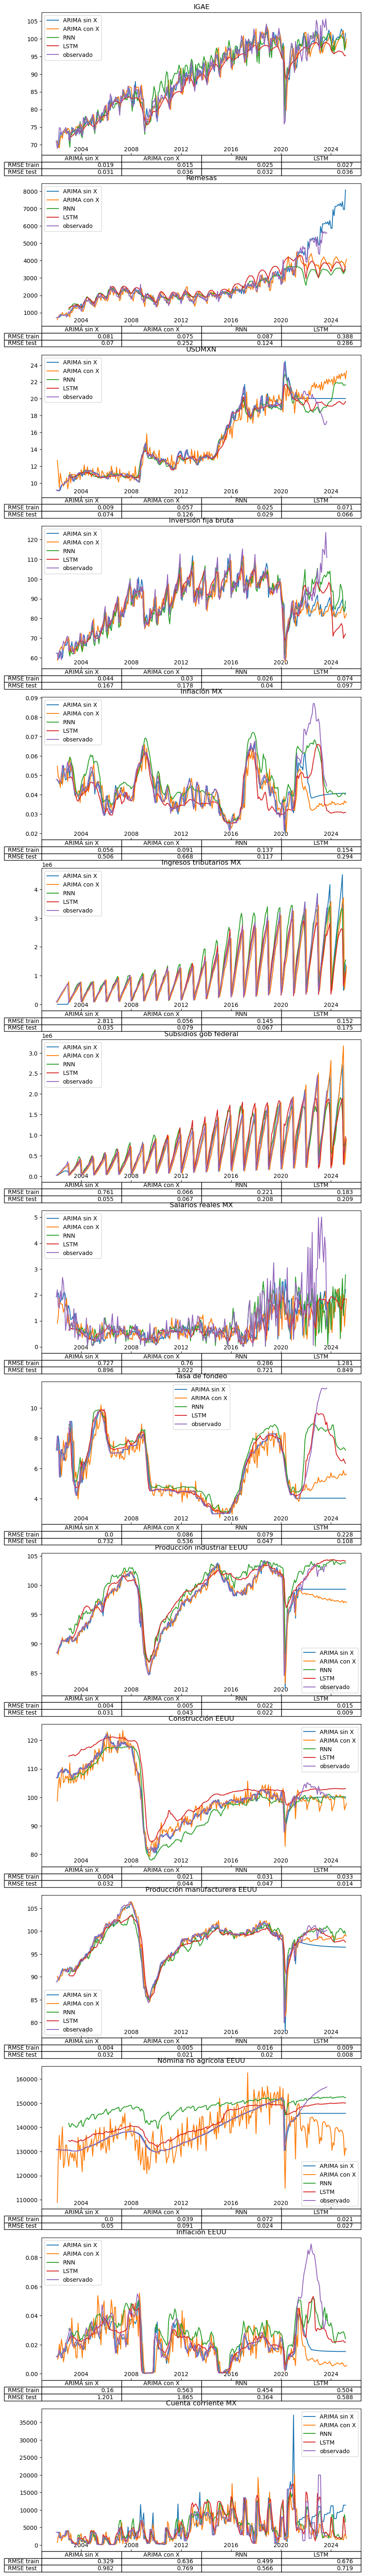

In [205]:
import matplotlib.pyplot as plt
T1=explicativas1.shape[1]

fig,ax=plt.subplots(T1,1,figsize=(10,80))

for i in range(T1):
    ax[i].plot(prelim1.index,np.exp(prelim1.iloc[:,i]),
               predicciones_conexp.index,np.exp(predicciones_conexp.iloc[:,i]),
               rnn_set.index,rnn_set.iloc[:,i],
               lstm_set.index,lstm_set.iloc[:,i],
               explicativas.index,explicativas.iloc[:,i])
    ax[i].legend(['ARIMA sin X','ARIMA con X','RNN','LSTM','observado'])
    ax[i].set_title(vars0[i])
    rmses00=pd.concat([rmse_arima1_set[vars0[i]],rmse_arima2_set[vars0[i]],rmse_rnn_set[vars0[i]],rmse_lstm_set[vars0[i]]],axis=1).set_axis(['ARIMA sin X','ARIMA con X','RNN','LSTM'],axis=1)
    ax[i].tick_params(axis="x",direction="in",pad=-15)
    ax[i].table(cellText=np.float32(rmses00).round(3),
                  rowLabels=rmses00.index,
                  colLabels=rmses00.columns,
                  loc='bottom')

### RMSE por modelo